# Preparation

In [1]:
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn 

import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.preprocessing import LabelEncoder

from scipy import stats
from scipy.stats import norm, skew
from scipy.special import boxcox1p

In [2]:
df_train = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv', index_col=0)
df_test = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv', index_col=0)

# EDA

Let's take a look at the data.

In [3]:
# Data Information
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [4]:
# Shape of Data
print(df_train.shape)
print(df_test.shape)

(1460, 80)
(1459, 79)


In [5]:
df_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [6]:
df_test.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [7]:
# About SalePrice
df_train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

skew: 1.882876 
kurt: 6.536282 


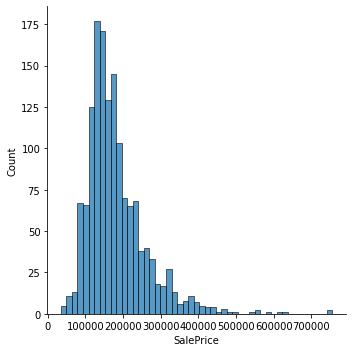

In [8]:
# SalePrice Distribution
sns.displot(df_train['SalePrice'])
print("skew: %f " % df_train['SalePrice'].skew())
print("kurt: %f " % df_train['SalePrice'].kurt())

So we can find that the y-variable SalePrice is a bit right-skewed and needs to be logarithmically processed afterwards to make it more closely match the normal distribution.

There are actually two kinds of features.

In [9]:
# Separate Numeric Features & Categorical Features
n_features = []
c_features = []
for col in df_test.columns:
    if df_test[col].dtype == 'object':
        c_features.append(col)
    else:
        n_features.append(col)
print('There are totally', len(n_features), 'numeric features. (Without Target-SalePrice)')
print('There are totally', len(c_features), 'categorical features.')

There are totally 36 numeric features. (Without Target-SalePrice)
There are totally 43 categorical features.


In [10]:
print(n_features)
print(c_features)

['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']
['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCon

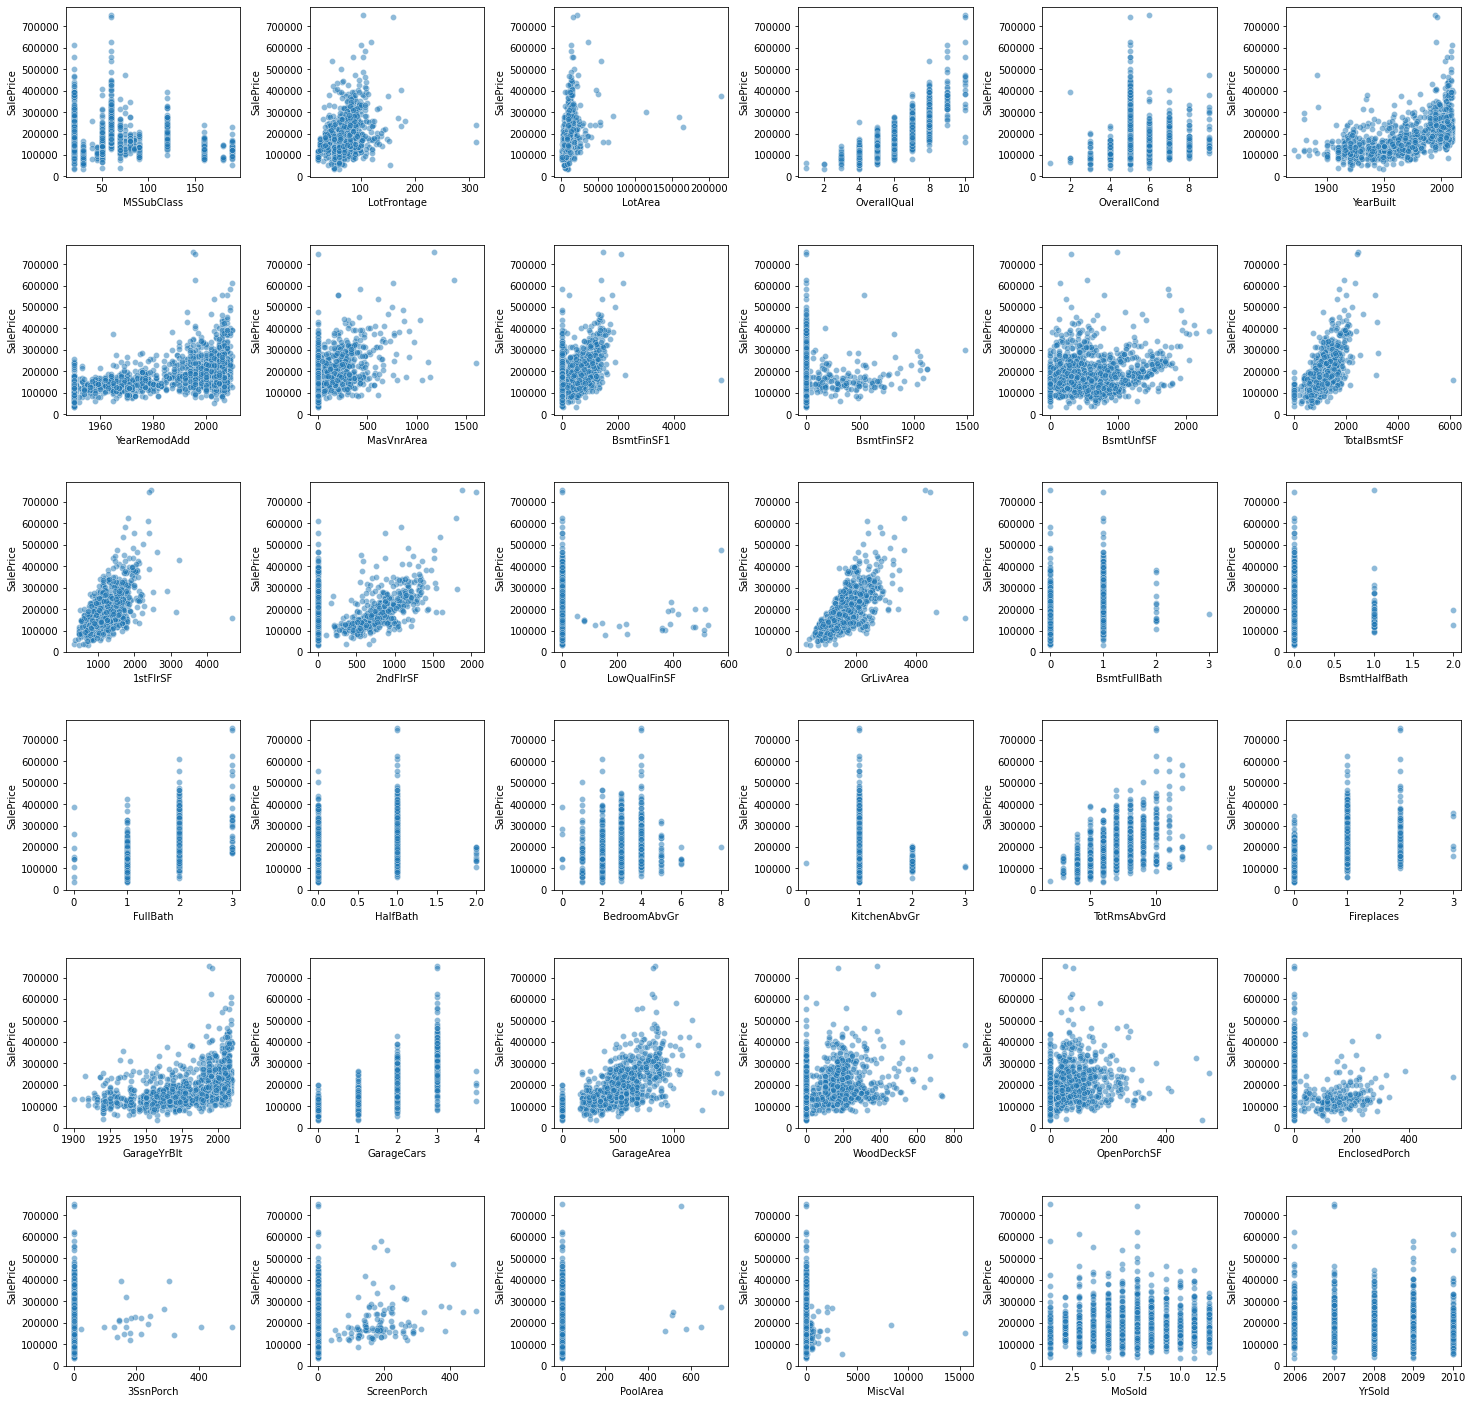

In [11]:
# About Numeric Features
plt.figure(figsize=(25, 25))
plt.subplots_adjust(hspace=0.4, wspace=0.4)
for i, feature in enumerate(n_features):
    plt.subplot(6, 6, i+1)
    sns.scatterplot(x=feature, y='SalePrice', data=df_train, alpha=0.5)
    plt.xlabel(feature)
    plt.ylabel('SalePrice')
plt.show()

In fact, from the above figure and data_description.txt, we can see that some numeric features such as OverallQual are actually categorical features, which have been converted to numeric features. Similarly, in the subsequent processing, we have to transform the categorical features, and it is necessary to distinguish that most of the features are in sequential relationship just like OverallQual.

<AxesSubplot:>

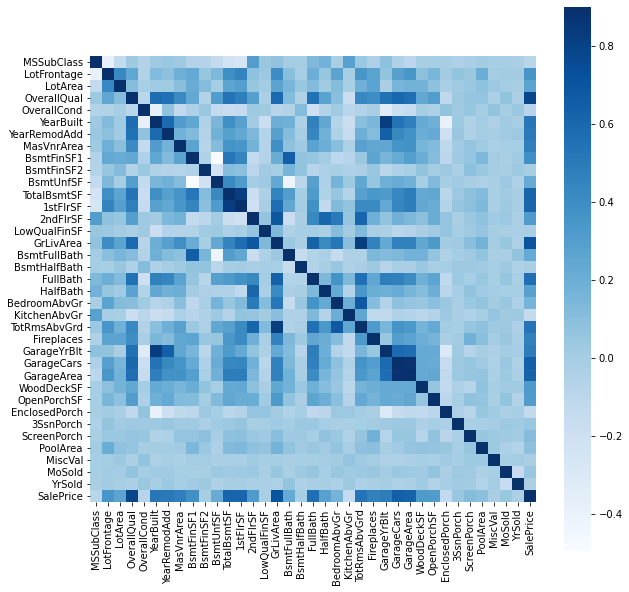

In [12]:
# Correlation (Numeric)
corr = df_train.corr()
plt.subplots(figsize=(10,10))
sns.heatmap(corr, vmax=0.9, cmap="Blues", square=True)

<AxesSubplot:>

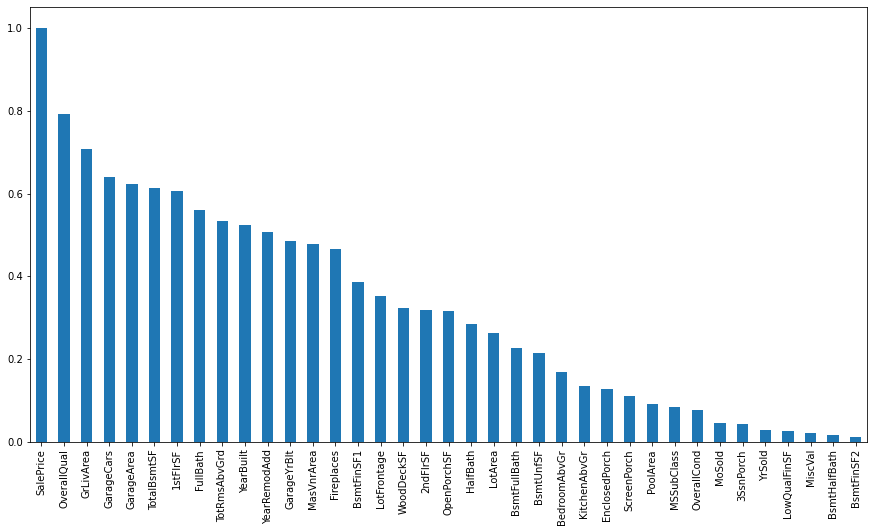

In [13]:
# Correlation with SalePrice (Numeric)
fig = plt.figure(figsize=(15,8))
abs(df_train.corr()['SalePrice']).sort_values(ascending=False).plot.bar()

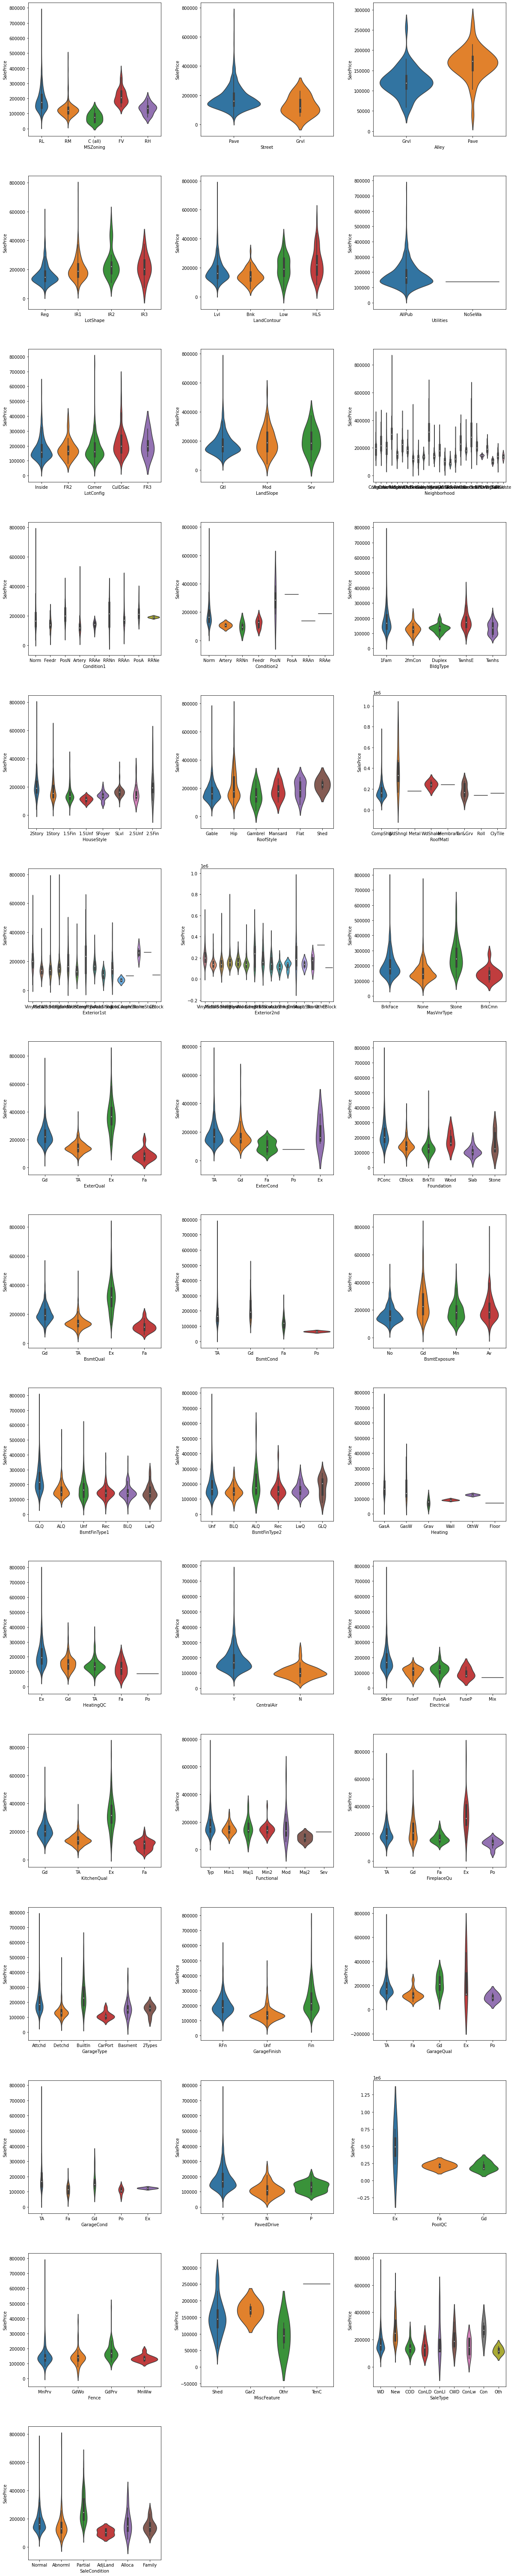

In [14]:
# About Categorical Features
plt.figure(figsize=(20, 110))
plt.subplots_adjust(hspace=0.3, wspace=0.3)
for i, feature in enumerate(c_features):
    plt.subplot(15, 3, i+1)
    sns.violinplot(x=feature, y="SalePrice", data=df_train)
    plt.xlabel(feature)
    plt.ylabel('SalePrice')
plt.show()

# Data Processing & Feature Engineering

Use Log-Transformation to make SalePrice match normal distribution.

skew: 0.121347 
kurt: 0.809519 


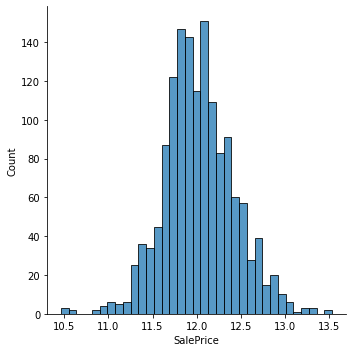

In [15]:
# Use log(1+x) to transform 
df_train['SalePrice'] = np.log1p(df_train['SalePrice'])

sns.displot(df_train['SalePrice'])
print("skew: %f " % df_train['SalePrice'].skew())
print("kurt: %f " % df_train['SalePrice'].kurt())

What about missing values? I concatenate df_train and df_test first.

In [16]:
# Merge them
y_train = df_train['SalePrice'].values
all_data = pd.concat((df_train, df_test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))
print("y_train shape is : {}".format(y_train.shape))

all_data size is : (2919, 79)
y_train shape is : (1460,)


In [17]:
# Features with Missing Data (NaN)
withna_total = all_data.isnull().sum().sort_values(ascending=False)
missing_rate = ((all_data.isnull().sum() / len(all_data)) * 100).sort_values(ascending=False)
missing_data = pd.concat([withna_total, missing_rate], axis=1, keys=['Total','Missing Rate'])
missing_data.head(35)

,Total,Missing Rate
PoolQC,2909,99.657417
MiscFeature,2814,96.402878
Alley,2721,93.216855
Fence,2348,80.438506
FireplaceQu,1420,48.646797
LotFrontage,486,16.649538
GarageYrBlt,159,5.447071
GarageFinish,159,5.447071
GarageQual,159,5.447071
GarageCond,159,5.447071


Text(0.5, 1.0, 'Missing Rate - Feature')

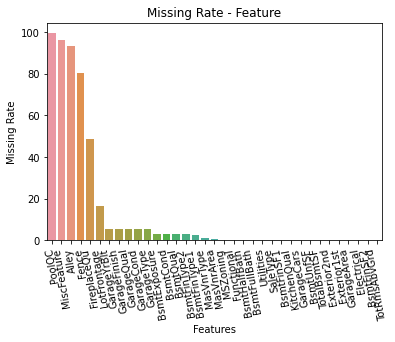

In [18]:
# Missing Data Ranking
plt.xticks(rotation='100')
sns.barplot(x=missing_rate.head(35).index, y=missing_rate.head(35))
plt.xlabel('Features')
plt.ylabel('Missing Rate')
plt.title('Missing Rate - Feature')

The meaning of missing data is different which is defined in description. When filling in missing values, the feature type should be taken into account. Unless the meaning of NaN is explicitly explained in the data_description.txt, NaN is generally filled with 0 for numeric features and None for categorical features.

For Categorical Features

In [19]:
# None_lists: no such a feature and fill with None
none_lists = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 
              'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType']
for col in none_lists:
    all_data[col] = all_data[col].fillna('None')

In [20]:
# Freq_lists: the value miss and fill with the most frequent value in this feature
freq_lists = ['MSZoning', 'Exterior1st', 'Exterior2nd', 'SaleType', 'KitchenQual', 'Electrical']
for col in freq_lists:
    all_data[col] = all_data[col].fillna(all_data[col].mode()[0])

In [21]:
# special features
all_data['Functional'] = all_data['Functional'].fillna('Typ') # NaN means typical
all_data.drop(['Utilities', 'Street', 'PoolQC'], axis=1, inplace=True) # single value, useless

For Numeric Features

In [22]:
# zero_lists: the value equals to 0 and fill with 0
zero_lists = ['GarageYrBlt', 'GarageCars', 'GarageArea', 'MasVnrArea', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
              'TotalBsmtSF']
for col in zero_lists:
    all_data[col] = all_data[col].fillna(0)

In [23]:
# Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

In [24]:
# Check if there are still missing values
isna_total = all_data.isnull().sum().sort_values(ascending=False)
isna_total.head(5)

MSSubClass      0
BedroomAbvGr    0
GarageType      0
FireplaceQu     0
Fireplaces      0
dtype: int64

Then let's handle the categorical features. When we transform discrete data, if there is no significance of size between the values of the features then use OneHot encoding, and conversely if there is significance of size between the values of the discrete features then use the mapping of values for encoding (incremental encoding).

We usually use pd.get_dummies() for OneHot encoding and sklearn.preprocessing.LabelEncoder() for incremental encoding. It's the same in this case.

We can distinguish these two kinds of categorical features according to figure and data_description.txt.

In [25]:
# Deal with some numerical features which are actually categorical 

# MSSubClass: the type of dwelling involved in the sale
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)

# GarageYrBlt: Year garage was built
all_data['GarageYrBlt'] = all_data['GarageYrBlt'].astype(str)

#Year and month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

In [26]:
# Features of all_data
num_features = []
cat_features = []
for col in all_data.columns:
    if all_data[col].dtype == 'object':
        cat_features.append(col)
    else:
        num_features.append(col)
print('There are totally', len(num_features), 'numeric features.')
print('There are totally', len(cat_features), 'categorical features.')
print(num_features)
print(cat_features)

There are totally 32 numeric features.
There are totally 44 categorical features.
['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']
['MSSubClass', 'MSZoning', 'Alley', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageYrBlt', '

In [27]:
# Incremental Encoding   
ie_features = ['Alley', 'LotShape', 'LandContour', 'LandSlope', 'HouseStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterQual', 
               'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'CentralAir',
               'KitchenQual', 'Functional', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'Fence', 
               'GarageYrBlt', 'YrSold', 'MoSold']
print(len(ie_features))

for col in ie_features:
    encoder = LabelEncoder()
    encoder.fit(list(all_data[col].values))
    all_data[col] = encoder.transform(list(all_data[col].values))
    
print(all_data.shape)

29
(2919, 76)


Fixing Skewness by Box Cox

In [28]:
# Check the skew(>0.5) of all numerical features
skewness = all_data[num_features].apply(lambda x: skew(x)).sort_values(ascending=False)
skewness = skewness[skewness>0.5]
skewness = pd.DataFrame({'Skewness' :skewness})
skewness.head(20)

,Skewness
MiscVal,21.947195
PoolArea,16.898328
LotArea,12.822431
LowQualFinSF,12.088761
3SsnPorch,11.376065
KitchenAbvGr,4.302254
BsmtFinSF2,4.146143
EnclosedPorch,4.003891
ScreenPorch,3.946694
BsmtHalfBath,3.931594


In [29]:
skew_features = skewness.index
for col in skew_features:
    lam = stats.boxcox_normmax(all_data[col]+1)    # make sure the input>0
    all_data[col] = boxcox1p(all_data[col], lam)

Finally we can get dummy categorical features.

In [30]:
dum_features = list(set(cat_features).difference(set(ie_features)))
print(dum_features)
print(len(dum_features))
all_data = pd.get_dummies(all_data)
print(all_data.shape)

['LotConfig', 'BldgType', 'Neighborhood', 'MasVnrType', 'SaleCondition', 'GarageType', 'Condition1', 'MiscFeature', 'MSZoning', 'Electrical', 'SaleType', 'MSSubClass', 'RoofStyle', 'Heating', 'Condition2']
15
(2919, 182)


In [31]:
# Re Divide 
trainset = all_data[:1460]
testset = all_data[1460:]
print('The shape of training data:', trainset.shape)
print('The shape of testing data:', testset.shape)

The shape of training data: (1460, 182)
The shape of testing data: (1459, 182)


# Modelling

In [32]:
# tools
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error

# models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, BayesianRidge
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR, LinearSVR
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from mlxtend.regressor import StackingCVRegressor

In [33]:
# Cross-validation with k-folds
n_folds = 10

def rmse_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(trainset.values)
    rmse= np.sqrt(-cross_val_score(model, trainset.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

Test different models with default parameters.(No RobustScaler)

In [34]:
models = [LinearRegression(),Ridge(),Lasso(),ElasticNet(),BayesianRidge(),
          AdaBoostRegressor(),RandomForestRegressor(),GradientBoostingRegressor(),ExtraTreesRegressor(),
          SVR(),LinearSVR(),LGBMRegressor(),XGBRegressor()]
names = ["LinearRegression","Ridge","Lasso","ElasticNet","BayesianRidge",
         "AdaBoostRegressor","RandomForestRegressor","GradientBoostingRegressor","ExtraTreesRegressor",
         "SVR","LinearSVR","LGBMRegressor","XGBRegressor"]

for i, model in enumerate(models):
    score = rmse_cv(model)
    print('{} score: {}({})'.format(names[i], score.mean(), score.std()))

LinearRegression score: 0.1346280930916458(0.02590997006545643)
Ridge score: 0.12876110437370375(0.026000370971994532)
Lasso score: 0.20694767616682(0.0337289688719744)
ElasticNet score: 0.2008299077572578(0.033581418826764124)
BayesianRidge score: 0.12618160342321233(0.027544505228752403)
AdaBoostRegressor score: 0.1749382814215638(0.012271488191610684)
RandomForestRegressor score: 0.1400328980821337(0.01905614981004594)
GradientBoostingRegressor score: 0.12727082008585142(0.019797963491086874)
ExtraTreesRegressor score: 0.1347170915175771(0.019410213882881226)
SVR score: 0.20260729874928968(0.02705718239067142)
LinearSVR score: 0.21385178451457176(0.04875367803053678)
LGBMRegressor score: 0.12900108030590215(0.020275586754131263)
XGBRegressor score: 0.1377954477001244(0.0183000049364915)


Then try to find optimal parameters for each model.

In [54]:
# Ridge
ridge = make_pipeline(RobustScaler(),Ridge())

para_grid = {'ridge__alpha':[0.1,1.0,5.0,10,10.5,11,11.5,11.7,12,12.3,12.5,13,13.5,14,14.5]}
grid = GridSearchCV(estimator=ridge, param_grid = para_grid, cv=10, scoring="neg_mean_squared_error")
grid.fit(trainset, y_train)

print(grid.best_params_, np.sqrt(-grid.best_score_))

{'ridge__alpha': 11.7} 0.12791458530362687


In [55]:
# Lasso
lasso = make_pipeline(RobustScaler(),Lasso())

para_grid = {'lasso__alpha':[0.00005,0.0001,0.0002,0.0005,0.001,0.002,0.005,0.01,0.1,0.5,1.0]}
grid = GridSearchCV(estimator=lasso, param_grid = para_grid, cv=10, scoring="neg_mean_squared_error")
grid.fit(trainset, y_train)

print(grid.best_params_, np.sqrt(-grid.best_score_))

{'lasso__alpha': 0.0005} 0.12780478984601504


In [56]:
# ElasticNet
enet = make_pipeline(RobustScaler(),ElasticNet())

para_grid = {'elasticnet__alpha':[0.0005,0.0008,0.004,0.005],'elasticnet__l1_ratio':[0.08,0.1,0.2,0.5,0.6,0.8,0.9]}
grid = GridSearchCV(estimator=enet, param_grid = para_grid, cv=10, scoring="neg_mean_squared_error")
grid.fit(trainset, y_train)

print(grid.best_params_, np.sqrt(-grid.best_score_))

{'elasticnet__alpha': 0.004, 'elasticnet__l1_ratio': 0.08} 0.1273445418686381


In [64]:
# BayesianRidge (Default is better)
bayridge = make_pipeline(RobustScaler(),BayesianRidge())

para_grid = {'bayesianridge__alpha_1':[0.0000000001,0.000000001,0.00000005,0.00000001,0.0000001,0.000005,0.00001,0.0001,]}
grid = GridSearchCV(estimator=bayridge, param_grid = para_grid, cv=10, scoring="neg_mean_squared_error")
grid.fit(trainset, y_train)

print(grid.best_params_, np.sqrt(-grid.best_score_))

{'bayesianridge__alpha_1': 1e-10} 0.12799861391823283


In [68]:
# SVR 
svr = make_pipeline(RobustScaler(),SVR())

para_grid = {'svr__C':[2,3,4,5,6],"svr__epsilon":[0.007,0.008,0.009,0.01]}
grid = GridSearchCV(estimator=svr, param_grid = para_grid, cv=10, scoring="neg_mean_squared_error")
grid.fit(trainset, y_train)

print(grid.best_params_, np.sqrt(-grid.best_score_))

{'svr__C': 2, 'svr__epsilon': 0.01} 0.12907817616127812


In [72]:
# LinearSVR
lsvr = make_pipeline(RobustScaler(),LinearSVR())

para_grid = {'linearsvr__C':[1,3,5,11,12,15],"linearsvr__epsilon":[0.005,0.010,0.02,0.03]}
grid = GridSearchCV(estimator=lsvr, param_grid = para_grid, cv=10, scoring="neg_mean_squared_error")
grid.fit(trainset, y_train)

print(grid.best_params_, np.sqrt(-grid.best_score_))

{'linearsvr__C': 1, 'linearsvr__epsilon': 0.02} 0.1376392672150581


In [71]:
# LGBMRegressor 
lgbm = make_pipeline(RobustScaler(),LGBMRegressor())

para_grid = {'lgbmregressor__learning_rate':[0.01,0.05,0.07],'lgbmregressor__n_estimators':[50,100,300],'lgbmregressor__max_depth':[6,8,10],'lgbmregressor__num_leaves':[30,40]}
grid = GridSearchCV(estimator=lgbm, param_grid = para_grid, cv=10, scoring="neg_mean_squared_error")
grid.fit(trainset, y_train)

print(grid.best_params_, np.sqrt(-grid.best_score_))

{'lgbmregressor__learning_rate': 0.05, 'lgbmregressor__max_depth': 6, 'lgbmregressor__n_estimators': 300, 'lgbmregressor__num_leaves': 30} 0.1281091011235657


In [73]:
# XGBRegressor
xgb = make_pipeline(RobustScaler(),XGBRegressor())

para_grid = {'xgbregressor__learning_rate':[0.1,0.2,0.3],'xgbregressor__max_depth':[3,5,7,9,11]}
grid = GridSearchCV(estimator=xgb, param_grid = para_grid, cv=10, scoring="neg_mean_squared_error")
grid.fit(trainset, y_train)

print(grid.best_params_, np.sqrt(-grid.best_score_))

{'xgbregressor__learning_rate': 0.2, 'xgbregressor__max_depth': 3} 0.12708982270433503


Check each model's score with new parameters.

In [74]:
lr = make_pipeline(RobustScaler(),LinearRegression())
ridge = make_pipeline(RobustScaler(),Ridge(alpha=11.7))
lasso = make_pipeline(RobustScaler(),Lasso(alpha=0.0005))
enet = make_pipeline(RobustScaler(),ElasticNet(alpha=0.004,l1_ratio=0.08))
bayridge = make_pipeline(RobustScaler(),BayesianRidge(alpha_1=0.005))
adaboost = make_pipeline(RobustScaler(),AdaBoostRegressor())
rfr= make_pipeline(RobustScaler(),RandomForestRegressor())
gbr = make_pipeline(RobustScaler(),GradientBoostingRegressor())
etr = make_pipeline(RobustScaler(),ExtraTreesRegressor())
svr = make_pipeline(RobustScaler(),SVR(C=2,epsilon=0.01))
lsvr = make_pipeline(RobustScaler(),LinearSVR(C=1,epsilon=0.02))
lgbm = make_pipeline(RobustScaler(),LGBMRegressor(learning_rate=0.05, max_depth=6,n_estimators=300,num_leaves=30))
xgb = make_pipeline(RobustScaler(),XGBRegressor(learning_rate=0.2,max_depth=3))

In [75]:
models = [lr,ridge,lasso,enet,bayridge,adaboost,rfr,gbr,etr,svr,lsvr,lgbm,xgb]
models_name = ["LinearRegression","Ridge","Lasso","ElasticNet","BayesianRidge",
         "AdaBoostRegressor","RandomForestRegressor","GradientBoostingRegressor","ExtraTreesRegressor",
         "SVR","LinearSVR","LGBMRegressor","XGBRegressor"]
for i, model in enumerate(models):
  score = rmse_cv(model)
  print('{} score: {}({})'.format(models_name[i], score.mean(), score.std()))

LinearRegression score: 0.13462809309164586(0.02590997006545727)
Ridge score: 0.12510810332166894(0.026647769449870927)
Lasso score: 0.12491341162258222(0.027031535368739347)
ElasticNet score: 0.12450005351118232(0.0267650708843834)
BayesianRidge score: 0.1252185752858129(0.02653214808355939)
AdaBoostRegressor score: 0.17482149366316285(0.011416717616681352)
RandomForestRegressor score: 0.1412798080824283(0.01829567100883263)
GradientBoostingRegressor score: 0.1270140802143132(0.020030371151203846)
ExtraTreesRegressor score: 0.13443535041978(0.01978888448667965)
SVR score: 0.1269146995927498(0.023533690496902765)
LinearSVR score: 0.13536211141230464(0.032368550308115106)
LGBMRegressor score: 0.12660032255070736(0.019603574182909433)
XGBRegressor score: 0.12572300818594434(0.018588928094332942)


Model Ensembling

In [76]:
# Ensembling by Stacking
stack_model = StackingCVRegressor(regressors=(lr,ridge,lasso,enet,bayridge,adaboost,rfr,gbr,etr,svr,lsvr,lgbm,xgb), meta_regressor=lasso, use_features_in_secondary=True)

In [78]:
# Training

#LinearRegression
lr_trained = lr.fit(np.array(trainset), np.array(y_train))
#Ridge
ridge_trained = ridge.fit(np.array(trainset), np.array(y_train))
#Lasso
lasso_trained = lasso.fit(np.array(trainset), np.array(y_train))
#ElasticNet
enet_trained = enet.fit(np.array(trainset), np.array(y_train))
#BayesianRidge
bayridge_trained = bayridge.fit(np.array(trainset), np.array(y_train))
#AdaBoostRegressor
adaboost_trained = adaboost.fit(np.array(trainset), np.array(y_train))
#RandomForestRegressor
rfr_trained = rfr.fit(np.array(trainset), np.array(y_train))
#GradientBoostingRegressor
gbr_trained = gbr.fit(np.array(trainset), np.array(y_train))
#ExtraTreesRegressor
etr_trained = etr.fit(np.array(trainset), np.array(y_train))
#SVR
svr_trained = svr.fit(np.array(trainset), np.array(y_train))
#LinearSVR
lsvr_trained = lsvr.fit(np.array(trainset), np.array(y_train))
#LGBMRegressor
lgbm_trained = lgbm.fit(np.array(trainset), np.array(y_train))
#XGBRegressor
xgb_trained = xgb.fit(np.array(trainset), np.array(y_train))

#Stacking
stack_model_trained = stack_model.fit(np.array(trainset), np.array(y_train))

In [79]:
def pred_rmse(y, y_preds):
  return np.sqrt(mean_squared_error(y, y_preds))

models = [lr,ridge,lasso,enet,bayridge,adaboost,rfr,gbr,etr,svr,lsvr,lgbm,xgb,stack_model]
models_name = ["LinearRegression","Ridge","Lasso","ElasticNet","BayesianRidge",
         "AdaBoostRegressor","RandomForestRegressor","GradientBoostingRegressor","ExtraTreesRegressor",
         "SVR","LinearSVR","LGBMRegressor","XGBRegressor","StackingModel"]
for i, model in enumerate(models):
  y_preds = model.predict(np.array(trainset))
  model_score = pred_rmse(y_train, y_preds)
  print('RMSE of {}: {}'.format(models_name[i], model_score))

RMSE of LinearRegression: 0.10667556791313654
RMSE of Ridge: 0.11119363614089145
RMSE of Lasso: 0.11193257270793515
RMSE of ElasticNet: 0.11238820944386113
RMSE of BayesianRidge: 0.11044934546243494
RMSE of AdaBoostRegressor: 0.15174074527418763
RMSE of RandomForestRegressor: 0.05408119012347537
RMSE of GradientBoostingRegressor: 0.08197938333410805
RMSE of ExtraTreesRegressor: 1.3169466664320883e-14
RMSE of SVR: 0.0553079683070935
RMSE of LinearSVR: 0.11996354522256025
RMSE of LGBMRegressor: 0.05284252909659762
RMSE of XGBRegressor: 0.07238577526399703
RMSE of StackingModel: 0.05346794019632691


Submission

In [81]:
preds = stack_model.predict(np.array(testset))
sample=pd.read_csv('../input/house-prices-advanced-regression-techniques/sample_submission.csv')
submission=pd.DataFrame({"Id":sample['Id'],"SalePrice":np.expm1(preds)})
submission.to_csv('submission.csv',index=False)

In [83]:
submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Id         1459 non-null   int64  
 1   SalePrice  1459 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 22.9 KB
